# 传统图像分类网络架构

In [41]:
import torch as t
import torchvision as tv
from torch import Tensor
from torch.nn import  Module
import cv2
import numpy as np
model = tv.models.squeezenet1_1(True)
model.eval()
print(model.__str__())

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

为什么叫resnet18，将权重层提出来，刚刚好是18层

In [42]:
for name,_ in model.named_parameters():
    if name.find("conv")!=-1 or name.find("fc")!=-1:
        print(name)

# 注册钩子，获取卷积层的输出

In [44]:
features=[]

def hook_features(module:Module,input:Tensor,output:Tensor):
    features.append(output.detach().numpy())


# 注册钩子
model._modules.get("features").register_forward_hook(hook_features)



# 将图片丢入网络中

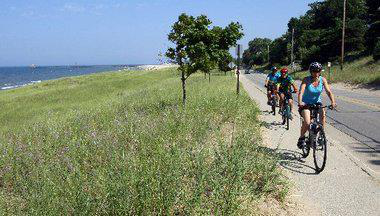

In [45]:
# 归一化
normalize = tv.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess =  tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    normalize
])
import PIL.Image
img = PIL.Image.open(r"D:\大四上\SDU\Reinforcement learning\Code\PytorchAndPythonLearning\Pytorch\ModernCNN\CAM\test.jpg")

img

In [46]:
# 丢到神经网络中，获得分类结果

img_tensor = preprocess.__call__(img)
img_tensor=img_tensor.unsqueeze(0)

img_tensor.shape
# B C H W

torch.Size([1, 3, 224, 224])

In [47]:
logit = model.forward(img_tensor)

logit.shape

torch.Size([1, 1000])

# 获得1000类的标签

In [48]:
# load the imagenet category list
import json
LABELS_file=r"D:\大四上\SDU\Reinforcement learning\Code\PytorchAndPythonLearning\Pytorch\ModernCNN\CAM\imagenet-simple-labels.json"
with open(LABELS_file) as f:
    classes = json.load(f)

classes

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [49]:
# 获取各类的概率
import torch.nn.functional as F
softmax_logit =  F.softmax(logit,1).squeeze()

print(softmax_logit.shape)

probs,idx = softmax_logit.sort(0,True)

# 输出结果
for i in range(0, 5):
    print(
        '{:.3f} -> {}, logit is {}'.format(probs[i], classes[idx[i]], logit[0][idx[i]]))


torch.Size([1000])
0.687 -> mountain bike, logit is 19.42284393310547
0.096 -> tandem bicycle, logit is 17.46003532409668
0.050 -> unicycle, logit is 16.807613372802734
0.033 -> horse-drawn vehicle, logit is 16.38227081298828
0.018 -> lakeshore, logit is 15.756912231445312


In [50]:
out_feature = features[0].squeeze()
out_feature.shape

(512, 13, 13)

# 提取线性层参数进行点乘

In [51]:
params = list(model.parameters())
weight_softmax = params[-2].detach().squeeze()

weight_softmax.shape

torch.Size([1000, 512])

In [52]:
# 将类别最大的那个下标提取出来
print(idx[0])

weight_max_prob = weight_softmax[idx[0]]

weight_max_prob.shape

tensor(671)


torch.Size([512])

In [53]:
pooling_map = F.adaptive_avg_pool2d(t.tensor(out_feature).unsqueeze(0), (1, 1)).squeeze(0)
print(pooling_map.shape)
class_activation_mapping = (pooling_map*weight_max_prob.unsqueeze(1).unsqueeze(1)).squeeze()
values,idx_max_prob=class_activation_mapping.sort(0,True)

for i in range(10):
    print(
        f"max idx = {idx_max_prob[i]}, the value is {values[i]},the weight value is {weight_max_prob[idx_max_prob[i]]}")


torch.Size([512, 1, 1])
max idx = 308, the value is 1.4843566417694092,the weight value is 0.1527361422777176
max idx = 367, the value is 1.278063416481018,the weight value is 0.07988044619560242
max idx = 6, the value is 1.0408515930175781,the weight value is 0.07807513326406479
max idx = 341, the value is 1.0323827266693115,the weight value is 0.053179141134023666
max idx = 154, the value is 0.9255968928337097,the weight value is 0.10159932076931
max idx = 191, the value is 0.7105045318603516,the weight value is 0.0904742181301117
max idx = 426, the value is 0.6947715878486633,the weight value is 0.04301335662603378
max idx = 205, the value is 0.6684693694114685,the weight value is 0.06722770631313324
max idx = 472, the value is 0.6321919560432434,the weight value is 0.05459760129451752
max idx = 378, the value is 0.5830488801002502,the weight value is 0.0760769471526146


In [58]:
cam=out_feature[idx_max_prob[4]]
print(cam)
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
cv2.imshow("123,",cv2.applyColorMap(cv2.resize(cam_img, img.size), cv2.COLORMAP_JET))
cv2.waitKey()

[[ 43.56983     29.565845    31.933922    47.118465    60.42436
   61.589622    44.212646    33.60026     69.0399     107.820694
   82.32206      0.           0.        ]
 [ 28.438486    13.181587    16.102207    41.513924    52.918774
   42.94413      9.854756     0.          15.087593    38.162025
    0.           0.           0.        ]
 [ 31.878918    18.02501     12.4180355   35.584938    54.740997
   56.24237     11.749204     1.5164015   26.835989     3.8291936
    0.           0.           0.        ]
 [ 46.26645     18.839842    19.266792    24.308086    58.69712
   42.93292      0.59864557   0.           5.369327     0.
    0.           0.           0.        ]
 [ 40.63519      9.123703     0.           0.           0.15291782
    6.5816503    0.           0.           0.           0.
    0.           0.           0.        ]
 [  8.549949    29.168991     0.           5.2244644    8.9171505
    0.           0.           0.           0.           0.
    0.           0.       

-1